In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# 导入训练数据
df = pd.read_csv('../improved_data/xy_orbit.csv')
array = df.to_numpy()
array = array.T
t = array[0]
yy = array[1:]

# 假设我们有 n 个时间点的观测数据 (x, y)
n = t.size  # 时间点数量
x = yy[0]    # x坐标
y = yy[1]    # y坐标
vx = yy[2]   # vx
vy = yy[3]   # vy

# 加速度的计算
r = np.sqrt(x**2 + y**2)   # 距离
G = 6.67430e-11 * 86400**2   # 引力常数, m^3 kg^-1 s^-2
M = 1.989e30      # 太阳质量, kg
GM = G * M
x_ddot = -G * M * x / r**3
y_ddot = -G * M * y / r**3


# 构建设计矩阵
def build_design_matrix(x, y):
    denominator = (x**2 + y**2)**(3/2)
    Theta = np.column_stack([
        np.ones(len(x)),  # 常数项
        x,                # x
        y,                # y
        x**2,             # x^2
        y**2,             # y^2
        x * y,            # x * y
        GM * x / denominator,  # GM * x / r^3
        GM * y / denominator   # GM * y / r^3
    ])
    return Theta

# 简单稀疏化的函数
def lasso_with_refit(Theta, Theta_scaled, target, alpha, threshold=None):
    """
    使用 LASSO 模型并结合阈值稀疏化后重新拟合模型
    Args:
        Theta: 原始设计矩阵（未标准化）
        Theta_scaled: 标准化后的设计矩阵
        target: 目标值 (x_ddot 或 y_ddot)
        alpha: LASSO 正则化参数
        threshold: 稀疏化阈值，若为 None，则动态设置
    Returns:
        sparse_coefficients: 稀疏化后的系数
        refit_coefficients: 重新拟合后的系数
    """
    # 第一步：使用 Lasso 初次拟合
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(Theta_scaled, target)
    coefficients = lasso.coef_
    
    # 打印初始 LASSO 系数
    print("Initial LASSO coefficients:", coefficients)

    # 动态设置阈值
    if threshold is None:
        # 剔除接近 0 的值后动态计算阈值
        valid_coefficients = coefficients[np.abs(coefficients) > 1e-6]
        if len(valid_coefficients) > 0:
            threshold = np.median(np.abs(valid_coefficients))
        else:
            threshold = 0.0
    print("Dynamic threshold set to:", threshold)

    # 第二步：应用阈值稀疏化
    mask = np.abs(coefficients) >= threshold  # 筛选重要特征
    sparse_coefficients = np.where(mask, coefficients, 0)
    
    # 第三步：重新拟合模型，仅使用非零特征（恢复未标准化数据）
    if np.sum(mask) > 0:  # 如果存在非零特征
        Theta_refit = Theta[:, mask]  # 筛选非零特征对应的列
        refit_model = LinearRegression()  # 使用无正则化线性回归
        refit_model.fit(Theta_refit, target)
        refit_coefficients = np.zeros_like(coefficients)  # 初始化为全零
        refit_coefficients[mask] = refit_model.coef_  # 更新非零特征的系数
    else:
        refit_coefficients = sparse_coefficients  # 如果所有系数都为零，返回稀疏化结果
    
    return sparse_coefficients, refit_coefficients

# 设置参数
alpha = 1e-3  # 降低 Lasso 正则化强度
threshold = None  # 动态设置阈值

# 生成目标值和设计矩阵
Theta = build_design_matrix(x, y)
scaler = StandardScaler()
Theta_scaled = scaler.fit_transform(Theta)

# 针对 x_ddot 稀疏回归
sparse_coefficients_x, refit_coefficients_x = lasso_with_refit(Theta, Theta_scaled, x_ddot, alpha, threshold)
print("Sparse coefficients for x_ddot:", sparse_coefficients_x)
print("Refit coefficients for x_ddot:", refit_coefficients_x)

# 针对 y_ddot 稀疏回归
sparse_coefficients_y, refit_coefficients_y = lasso_with_refit(Theta, Theta_scaled, y_ddot, alpha, threshold)
print("Sparse coefficients for y_ddot:", sparse_coefficients_y)
print("Refit coefficients for y_ddot:", refit_coefficients_y)



Initial LASSO coefficients: [ 0.00000000e+00 -3.13123273e+07 -1.82281421e+00 -7.78830286e+05
  3.91266584e+03 -1.87060157e-01 -5.88006743e+04  1.77186329e+00]
Dynamic threshold set to: 3912.6658448720095
Sparse coefficients for x_ddot: [ 0.00000000e+00 -3.13123273e+07  0.00000000e+00 -7.78830286e+05
  3.91266584e+03  0.00000000e+00 -5.88006743e+04  0.00000000e+00]
Refit coefficients for x_ddot: [ 0.00000000e+00 -2.39025585e-23  0.00000000e+00  5.94613891e-14
  5.95767654e-14  0.00000000e+00 -7.08504778e-27  0.00000000e+00]
Initial LASSO coefficients: [ 0.00000000e+00 -7.46928902e+01 -3.13223850e+07 -6.58851452e+00
 -4.69286317e+00 -7.82120939e+05  7.41531307e+01 -3.25598014e+04]
Dynamic threshold set to: 74.69289022016095
Sparse coefficients for y_ddot: [ 0.00000000e+00 -7.46928902e+01 -3.13223850e+07  0.00000000e+00
  0.00000000e+00 -7.82120939e+05  0.00000000e+00 -3.25598014e+04]
Refit coefficients for y_ddot: [ 0.00000000e+00 -1.02731377e-12 -2.96413495e-04  0.00000000e+00
  0.00000

Lasso Coefficients for ax:
[ 0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.98641239 -0.        ]

Lasso Coefficients for ay:
[ 0.         -0.         -0.         -0.          0.         -0.
 -0.         -0.         -0.         -0.98732392]

OLS Coefficients for ax (after removing regularization):
[ 0.  0.  0.  0.  0.  0.  0.  0. -1.  0.]

OLS Coefficients for ay (after removing regularization):
[ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]


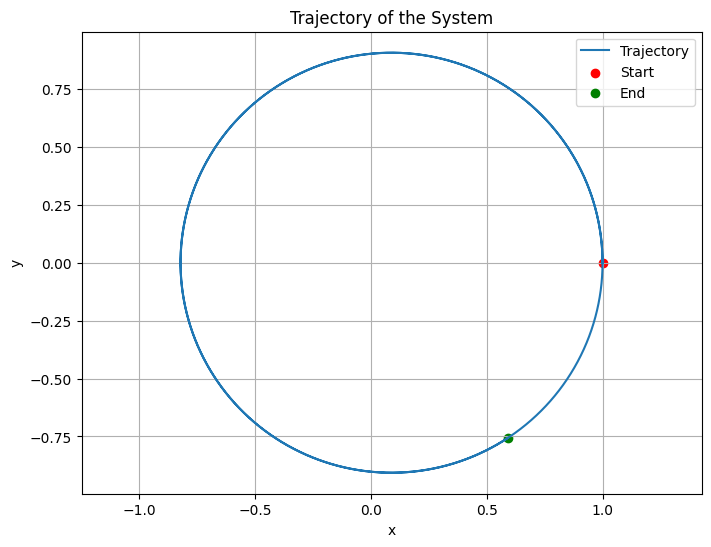

In [3]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LinearRegression

# 定义常数
G = 1.0  # 万有引力常数
M = 1.0  # 中心质量

# 定义微分方程组
def equations(t, state):
    x, y, vx, vy = state  # 状态变量: x, y, vx, vy
    r = np.sqrt(x**2 + y**2)  # 距离
    dxdt = vx
    dydt = vy
    dvxdt = -G * M * x / r**3
    dvydt = -G * M * y / r**3
    return [dxdt, dydt, dvxdt, dvydt]

# 初始条件
x0 = 1.0  # 初始 x 位置
y0 = 0.0  # 初始 y 位置
vx0 = 0.0  # 初始 x 速度
vy0 = 0.95 * np.sqrt(G * M / x0)  # 初始 y 速度 (确保椭圆轨迹)
initial_state = [x0, y0, vx0, vy0]

# 时间范围
t_span = (0, 10)  # 从 t=0 到 t=10
t_eval = np.linspace(t_span[0], t_span[1], 10000)  # 时间点 (增加时间点数量)

# 数值积分 (使用更高阶的积分方法)
sol = solve_ivp(equations, t_span, initial_state, t_eval=t_eval, method='DOP853', rtol=1e-10, atol=1e-10)

# 提取结果
t = sol.t  # 时间点
x = sol.y[0]  # x(t)
y = sol.y[1]  # y(t)
vx = sol.y[2]  # vx(t)
vy = sol.y[3]  # vy(t)

# 计算加速度 (二阶导数)
r = np.sqrt(x**2 + y**2)
ax = -G * M * x / r**3  # x 方向加速度
ay = -G * M * y / r**3  # y 方向加速度

# 生成数据集
data = np.column_stack([t, x, y, vx, vy, ax, ay])

# 定义候选基函数
def build_design_matrix(x, y):
    n = len(x)
    denominator = (x**2 + y**2)**(3/2)
    Theta = np.column_stack([
        np.ones(n),  # 常数项
        x,           # x
        y,           # y
        x**2,        # x^2
        y**2,        # y^2
        x * y,       # x * y
        x * y**2,
        y * x**2,
        x / denominator,  # x / (x^2 + y^2)^(3/2)
        y / denominator   # y / (x^2 + y^2)^(3/2)
    ])
    return Theta

# 构建生成矩阵
Theta = build_design_matrix(x, y)

# 使用 LASSO 回归
lasso = Lasso(alpha=0.01)  # alpha 是正则化参数
lasso.fit(Theta, ax)   # 拟合 x_ddot
coefficients_x_lasso = lasso.coef_

lasso.fit(Theta, ay)   # 拟合 y_ddot
coefficients_y_lasso = lasso.coef_

# 输出 Lasso 回归的系数
print("Lasso Coefficients for ax:")
print(coefficients_x_lasso)

print("\nLasso Coefficients for ay:")
print(coefficients_y_lasso)

# 第二步：去除正则化项，重新计算参数

# 获取Lasso模型中非零的系数索引
nonzero_indices_x = np.where(coefficients_x_lasso != 0)[0]
nonzero_indices_y = np.where(coefficients_y_lasso != 0)[0]

# 筛选出在Lasso中非零的特征
Theta_x = Theta[:, nonzero_indices_x]
Theta_y = Theta[:, nonzero_indices_y]

# 使用 OLS 进行重新拟合，去除正则化项
ols_x = LinearRegression()
ols_x.fit(Theta_x, ax)
coefficients_x_ols = ols_x.coef_

ols_y = LinearRegression()
ols_y.fit(Theta_y, ay)
coefficients_y_ols = ols_y.coef_

# 输出 OLS 回归的系数
print("\nOLS Coefficients for ax (after removing regularization):")
# 为了便于比较，显示与原始特征对应的OLS系数
full_coefficients_x_ols = np.zeros(Theta.shape[1])
full_coefficients_x_ols[nonzero_indices_x] = coefficients_x_ols
print(full_coefficients_x_ols)

print("\nOLS Coefficients for ay (after removing regularization):")
# 为了便于比较，显示与原始特征对应的OLS系数
full_coefficients_y_ols = np.zeros(Theta.shape[1])
full_coefficients_y_ols[nonzero_indices_y] = coefficients_y_ols
print(full_coefficients_y_ols)

# 可视化轨迹
plt.figure(figsize=(8, 6))
plt.plot(x, y, label='Trajectory')
plt.scatter(x[0], y[0], color='red', label='Start')
plt.scatter(x[-1], y[-1], color='green', label='End')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectory of the System')
plt.legend()
plt.grid()
plt.axis('equal')  # 确保 x 和 y 轴比例相同
plt.show()
